# Logistic 回归——Pima Indians Diabetes Data Set

数据说明：
Pima Indians Diabetes Data Set（皮马印第安人糖尿病数据集） 根据现有的医疗信息预测5年内皮马印第安人糖尿病发作的概率。   

数据集共9个字段: 
0列为怀孕次数；
1列为口服葡萄糖耐量试验中2小时后的血浆葡萄糖浓度；
2列为舒张压（单位:mm Hg）
3列为三头肌皮褶厚度（单位：mm）
4列为餐后血清胰岛素（单位:mm）
5列为体重指数（体重（公斤）/ 身高（米）^2）
6列为糖尿病家系作用
7列为年龄
8列为分类变量（0或1）

数据链接：https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

#评价指标为logloss
from sklearn.metrics import log_loss  

from matplotlib import pyplot

## 读取数据 

In [5]:
# 读取数据
train = pd.read_csv("FE_pima-indians-diabetes.csv")
train.head()

,pregnants,Plasma_glucose_concentration,blood_pressure,Triceps_skin_fold_thickness,serum_insulin,BMI,Diabetes_pedigree_function,Age,Target
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
Unnamed: 0                      768 non-null int64
pregnants                       768 non-null int64
Plasma_glucose_concentration    768 non-null float64
blood_pressure                  768 non-null float64
Triceps_skin_fold_thickness     768 non-null float64
serum_insulin                   768 non-null float64
BMI                             768 non-null float64
Diabetes_pedigree_function      768 non-null float64
Age                             768 non-null int64
Target                          768 non-null int64
dtypes: float64(6), int64(4)
memory usage: 60.1 KB


In [6]:
#  get labels
y_train = train['Target']   
X_train = train.drop(["Target"], axis=1)

## 数据预处理

In [7]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 初始化特征的标准化器
ss_X = StandardScaler()

# 分别对训练和测试数据的特征进行标准化处理
X_train = ss_X.fit_transform(X_train)

## 模型训练

### default Logistic Regression


In [8]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()

In [10]:
# 交叉验证用于评估模型性能和进行参数调优（模型选择）
#分类任务中交叉验证缺省是采用StratifiedKFold
from sklearn.model_selection import cross_val_score
loss = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_log_loss')
print 'logloss of each fold is: ',-loss
print'cv logloss is:', -loss.mean()

logloss of each fold is:  [ 0.48797856  0.53011593  0.4562292   0.422546    0.48392885]
cv logloss is: 0.476159709444


### 正则化的 Logistic Regression及参数调优
这部分用交叉验证GridSearchCV、LogisticRegressionCV任意一种方式均可

logistic回归的需要调整超参数有：C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 
目标函数为：J = C* sum(logloss(f(xi), yi)) +  penalty 

在sklearn框架下，不同学习器的参数调整步骤相同：
设置候选参数集合
调用GridSearchCV
调用fit

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#需要调优的参数
# 请尝试将L1正则和L2正则分开，并配合合适的优化求解算法（slover）
#tuned_parameters = {'penalty':['l1','l2'],
#                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#                   }
penaltys = ['l1','l2']
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression()
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=5, scoring='neg_log_loss')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [15]:
# examine the best model
print(-grid.best_score_)
print(grid.best_params_)

0.47602451921
{'penalty': 'l1', 'C': 1}


如果最佳值在候选参数的边缘，最好再尝试更大的候选参数或更小的候选参数，直到找到拐点。
l2, c=100

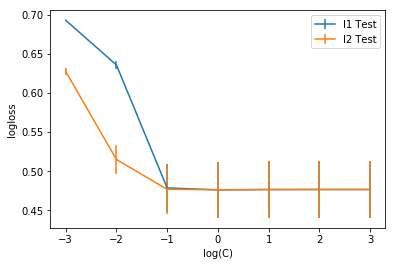

In [18]:
# plot CV误差曲线
test_means = -grid.cv_results_[ 'mean_test_score' ]
test_stds = grid.cv_results_[ 'std_test_score' ]
train_means = -grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]

# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores =  np.array(test_means).reshape(n_Cs,number_penaltys)
#train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_penaltys)
#train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    pyplot.errorbar(x_axis, test_scores[:,i], yerr=test_stds[:,i] ,label = penaltys[i] +' Test')
    #pyplot.errorbar(x_axis, train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys[i] +' Train')
    
pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'logloss' )
pyplot.savefig('LogisticGridSearchCV_C.png' )

pyplot.show()

上图给出了L1正则和L2正则下、不同正则参数C对应的模型在训练集上测试集上的正确率（score）。可以看出在训练集上C越大（正则越少）的模型性能越好；但在测试集上当C=100时性能最好（L1正则和L2正则均是）

## 换正确率做评价指标

In [20]:
penaltys = ['l1','l2']
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression()

#缺省scoring为正确率
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=5)
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

0.774739583333
{'penalty': 'l2', 'C': 0.1}


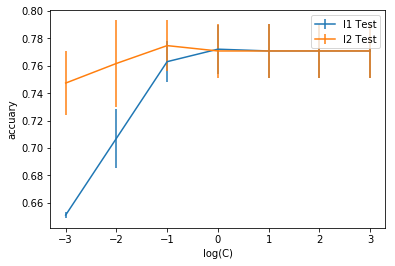

In [21]:
# plot CV误差曲线
test_means = grid.cv_results_[ 'mean_test_score' ]
test_stds = grid.cv_results_[ 'std_test_score' ]
train_means = grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]

# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores =  np.array(test_means).reshape(n_Cs,number_penaltys)
#train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_penaltys)
#train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    pyplot.errorbar(x_axis, test_scores[:,i], yerr=test_stds[:,i] ,label = penaltys[i] +' Test')
    #pyplot.errorbar(x_axis, train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys[i] +' Train')
    
pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'accuary' )
pyplot.savefig('LogisticGridSearchCV_C.png' )

pyplot.show()